# Visualisaiton of Squidpy Graph Data Structure

The following notebook works through some examples of squidpys graph data structure for ST data. The goal is to better understand how Squidpy creates their graphs and what is encoded within them.

Squidpy has mutliple methods for the graph data structure, the main two that will be examined are:
 - gr.spatial_neighbours()
 - gr.interaction_matrix()

`gr.spatial_neighbours()` generates the spatial neighbours for the ST data. Squidpy uses different approaches for different types of spatial datasets. The following work will explore how that works through visualisation

`gr.interaction_matrix()` quantifies the number of edges that are shared between annotations, acts as a descriptive statistic of the spatial graph. This notebook will breakdown how that works and what it means

## Spatial Graph and Spatial neighbours

### loading data and imports

In [16]:
import numpy as np
import squidpy as sq

adata = sq.datasets.visium_fluo_adata()

/home/duncanbrady/honours24/codebase/ST_Honours_2024/.venv/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [3]:
# Display the data summary and descriptors
adata

AnnData object with n_obs × n_vars = 2800 × 16562
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In order to compute the spatial neighbours graph for the data, the following inputs are given
 - coord_type : This defines how coordinates are given in the ST data, will default to 'grid'(visium) if the adata has spatial key with n_neigh = 6
 - n_neighs : Default value is 6, and relates to the coord types
 - n_rings : Only used with grid coord types, defines the number of rings of neighbours.

The function will build the spatial graph and save its adjaceny matrix to `adata.obsp['spatial_connectivities']` and with a weighted version being stored in `adata.obsp['spatial_distances']`.

{'cluster_colors': array(['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b',
       '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78', '#98df8a',
       '#ff9896', '#c5b0d5', '#c49c94'], dtype=object), 'hvg': {'flavor': 'seurat_v3'}, 'leiden': {'params': {'n_iterations': -1, 'random_state': 0, 'resolution': 0.7}}, 'leiden_colors': array(['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b',
       '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78', '#98df8a',
       '#ff9896', '#c5b0d5', '#c49c94'], dtype=object), 'neighbors': {'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'method': 'umap', 'metric': 'euclidean', 'n_neighbors': 15}}, 'pca': {'params': {'use_highly_variable': True, 'zero_center': True}, 'variance': array([47.675198  , 21.054596  , 16.050554  ,  8.638809  ,  7.6382565 ,
        5.491377  ,  4.5791574 ,  3.881314  ,  3.2301164 ,  2.706522  ,
        2.446258  ,  2.2620428 ,  1.9798301 ,  1.8956892 ,  1.7

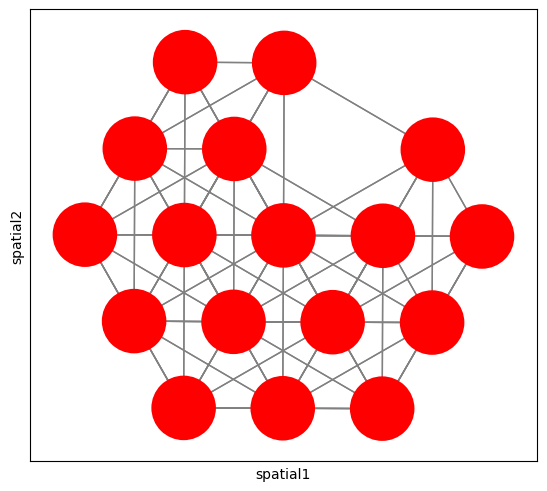

In [17]:

sq.gr.spatial_neighbors(adata, n_rings=2, coord_type="grid", n_neighs=6)
print(adata.uns)
print(adata.obsp["spatial_connectivities"])
point = 0
_, idx = adata.obsp["spatial_connectivities"][point, :].nonzero()
print(type(idx))
idx = np.append(idx,point)
print(len(idx))

sq.pl.spatial_scatter(
    adata[idx,:],
    connectivity_key="spatial_connectivities",
    img=False,
    na_color="red"
)

In [7]:
print(adata.obsp['spatial_distances'][0][0])

  (0, 948)	2.0
  (0, 2387)	2.0
  (0, 2770)	2.0
  (0, 678)	2.0
  (0, 1092)	2.0
  (0, 2344)	2.0
  (0, 427)	2.0
  (0, 1553)	2.0
  (0, 756)	2.0
  (0, 513)	2.0
  (0, 2580)	2.0
  (0, 2721)	1.0
  (0, 1779)	1.0
  (0, 797)	1.0
  (0, 357)	1.0
  (0, 301)	1.0


It is important to note that for the above work and the given data, it is not single cell resolution as it is 10xVisium. Squidpy has preprocessed this dataset to normalise and establish cell types for each spot. Thus the above visualisation each node is a spot within the data and edges are not representations of cell-interaction but rather connection between nodes. Need to understand how connections are detemined 

# Merfish Data

In [33]:
import scanpy as sc
import squidpy as sq
import gravis as gv
import networkx as nx

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

scanpy==1.9.8 anndata==0.10.6 umap==0.5.5 numpy==1.23.4 scipy==1.12.0 pandas==2.0.0 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11
squidpy==1.4.1


In [20]:
adata = sq.datasets.merfish()
adata

/home/duncanbrady/honours24/codebase/ST_Honours_2024/.venv/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 73655 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch'
    uns: 'Cell_class_colors'
    obsm: 'spatial', 'spatial3d'

/home/duncanbrady/honours24/codebase/ST_Honours_2024/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:327: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = ax.scatter(


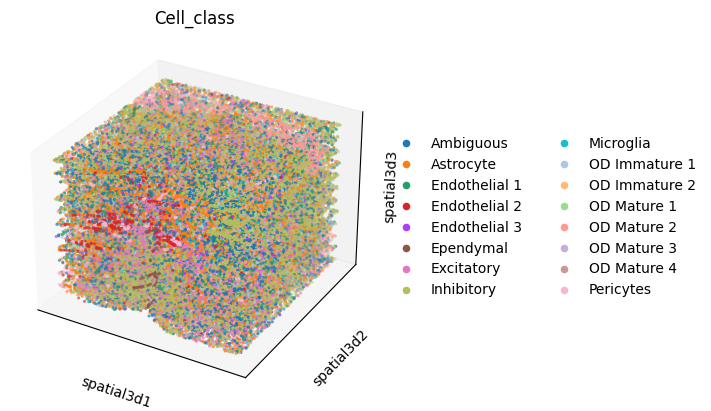

In [10]:
sc.pl.embedding(adata, basis="spatial3d", projection="3d", color="Cell_class")

In [27]:
sq.gr.spatial_neighbors(adata,spatial_key="spatial", coord_type="generic")
print(adata.uns)
print(adata.obsp)


{'Cell_class_colors': array(['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b',
       '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78', '#98df8a',
       '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2'], dtype=object), 'spatial_neighbors': {'connectivities_key': 'spatial_connectivities', 'distances_key': 'spatial_distances', 'params': {'n_neighbors': 6, 'coord_type': 'generic', 'radius': None, 'transform': None}}}
PairwiseArrays with keys: spatial_connectivities, spatial_distances


In [109]:
mer_net = nx.Graph()
spat_conn  = adata.obsp["spatial_connectivities"][:10].nonzero()
spat_dist = adata.obsp["spatial_distances"][:10].toarray()
print(spat_dist[1])
seenNodes = []
for i, j in zip(spat_conn[0], spat_conn[1]):
    if i not in seenNodes:
        mer_net.add_node(f"node_{i}", size=10)
        seenNodes.append(i+1)
    if j not in seenNodes:
        mer_net.add_node(f"node_{j}", size=10)
        seenNodes.append(j)
    mer_net.add_edge(f"node_{i}", f"node_{j}", weight=spat_dist[i][j])
gv.d3(mer_net)

[0. 0. 0. ... 0. 0. 0.]


In [106]:
import gravis as gv
import networkx as nx

g = nx.cycle_graph(10)
g.graph['node_color'] = 'blue'
g.nodes[1]['title'] = 'Number 1'
g.nodes[1]['group'] = 1
g.nodes[3]['title'] = 'I belong to a different group!'
g.nodes[3]['group'] = 10
g.nodes[3]['color'] = 'orange'
g.add_node(20, size=20, title='couple', group=2, color='red')
g.add_node(21, size=15, title='couple', group=2, color='red')
g.add_edge(20, 21, weight=5)
g.add_node(25, size=25, label='lonely', title='lonely node', group=3, color='green')

gv.d3(g)
